In [1]:
import numpy as np
# ^^^ pyforest auto-imports - don't write above this line
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
x,y = mnist['data'], mnist['target']
x.shape
# 28 X 28 pixels

(70000, 784)

In [3]:
y.shape

(70000,)

(-0.5, 27.5, 27.5, -0.5)

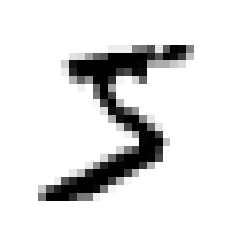

In [4]:
import matplotlib.pyplot as plt

plt.imshow(x[0].reshape(28,28), cmap='binary')
plt.axis('off')

In [5]:
y[0]

'5'

In [6]:
y = y.astype(np.uint8)

# for type casting y into integer

In [7]:
X_train, X_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

#### TRAINING A BINARY CLASSIFIER

In [8]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

In [ ]:
sgd_clf.predict([x[0]])

### IMPLEMENTING CROSS VALIDATION

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
'''Clone does a deep copy of the model in an
estimator without actually copying attached data.
It yields a new estimator with the same parameters
that has not been fit on any data.'''

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/ len(y_pred))

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
y_train_pred

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

In [ ]:
confusion_matrix(y_train_5, y_train_5)

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

In [ ]:
recall_score(y_train_5, y_train_pred)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

#### Decision functions

In [ ]:
# Decision function returns the score for each instance
y_scores = sgd_clf.decision_function([x[0]])
y_scores

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
plt.plot(thresholds, precisions[:-1],'b--', label='Precision')
plt.plot(thresholds, recalls[:-1],'g-', label='Recall')

In [ ]:
'''You may wonder why the precision curve is bumpier than the recall
curve . The reason is that precision may sometimes go
down when you raise the threshold (although in general it will go
up)'''

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

In [ ]:
recall_score(y_train_5, y_train_pred_90)

### ROC CURVE

In [ ]:
'''
ROC curve plots the true positive rate (another name
for recall) against the false positive rate (FPR). 
The FPR is the ratio of negative instances
that are incorrectly classified as positive.
It is equal to 1 – the true negative rate
(TNR), which is the ratio of negative instances
that are correctly classified as negative.
The TNR is also called specificity.
Hence, the ROC curve plots sensitivity (recall) versus
1 – specificity.
'''

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1],'k--')

In [ ]:
# A good classifier stays as far away from that line was possible
# A perfect classifier would have the area under curve equal to 1

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

In [ ]:
# Since the ROC curve is so similar to the precision/recall (PR)
# curve, you may wonder how to decide which one to use. As a rule
# of thumb, you should prefer the PR curve whenever the positive
# class is rare or when you care more about the false positives than
# the false negatives

### RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

In [ ]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_probas_forest[:,1])

In [ ]:
plt.plot(fpr, tpr, "b:",label='SGD')
plt.plot(fpr_forest, tpr_forest)

In [ ]:
roc_auc_score(y_train_5, y_probas_forest[:,1])

# MULTICLASS CLASSIFICATION

In [ ]:
# One way to create a system that can classify the digit images into 10 classes (from 0 to
# 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-
# detector, and so on). Then when you want to classify an image, you get the decision
# score from each classifier for that image and you select the class whose classifier outputs
# the highest score. This is called the one-versus-the-rest (OvR) strategy (also called
# one-versus-all).

In [ ]:
# Another strategy is to train a binary classifier for every pair of digits: one to distinguish
# 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
# This is called the one-versus-one (OvO) strategy. If there are N classes, you need to
# train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45
# binary classifiers! When you want to classify an image, you have to run the image
# through all 45 classifiers and see which class wins the most duels. The main advantage
# of OvO is that each classifier only needs to be trained on the part of the training
# set for the two classes that it must distinguish.

In [ ]:
# Some algorithms (such as Support Vector Machine classifiers) scale poorly with the
# size of the training set. For these algorithms OvO is preferred because it is faster to
# train many classifiers on small training sets than to train few classifiers on large training
# sets. For most binary classification algorithms, however, OvR is preferred.

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([x[0]])

In [ ]:
svm_clf.predict([x[0]])

In [ ]:
some_digit_scores = svm_clf.decision_function([x[0]])
some_digit_scores

In [ ]:
np.argmax(some_digit_scores)

In [ ]:
# When a classifier is trained, it stores the list of target classes in its
# classes_ attribute, ordered by value. In this case, the index of each
# class in the classes_ array conveniently matches the class itself
# (e.g., the class at index 5 happens to be class 5), but in general you
# won’t be so lucky.
svm_clf.classes_

#### OneVsRestClassifier

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

#### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

## MULTILABEL CLASSIFICATION

In [9]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([x[0]])

In [ ]:
# This code computes the average F1 score across all labels
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred ,average='macro')
# To give more importance to a specific label, set average = 'weighted'

## MULTIOUTPUT CLASSIFICATION

<!-- It is simply a generalization
of multilabel classification where each label can be multiclass (i.e., it can have
more than two possible values). --> 

In [10]:
# It is simply a generalization
# of multilabel classification where each label 
# can be multiclass (i.e., it can have
# more than two possible values).

In [11]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [12]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[x[0]]])


IndexError: arrays used as indices must be of integer (or boolean) type

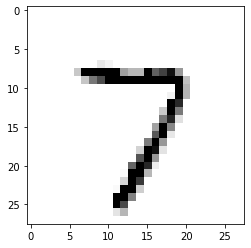

In [20]:
clean_digit = knn_clf.predict([X_test_mod[0]])
plt.imshow(clean_digit.reshape(28,28), cmap='binary')